<a href="https://colab.research.google.com/github/CesarRosales16/urban-sprawl-sv/blob/main/Expansion_Urbana_AMSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de la expansión urbana en el AMSS usando técnicas de Teledetección y Machine Learning

El Notebook, el código fuente generado, las fuentes de datos utilizadas, así como los resultados obtenidos y recursos adicionales se encuentran en el repositorio de Github: https://github.com/CesarRosales16/urban-sprawl-sv

## Preparación del ambiente de desarrollo

Se instala GeoPandas ya que por el momento no forma parte de las dependencias incluidas por defecto en Google Colab.

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 320 kB/s 
     |████████████████████████████████| 6.3 MB 9.0 MB/s 


Se importan las librerias necesarias.

In [ ]:
import ee 
import folium 
import pandas as pd
import geopandas as gpd 
import json
from google.colab import drive
import time 
import matplotlib.pyplot as plt

Se inicializan y autentican las librerias que lo requieren.

In [ ]:
# Trigger the EE authentication flow.
ee.Authenticate()

# Initialize the EE library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=raLd1hVkL1HAEVlxeVb8bHfOa2fWCuDOF_XuYe9NLbE&tc=GBwfXdUcHLxILoi1hMO7gsiTZ1dwWKj4fEJ1JkALtEw&cc=mVppaSJozDc-sf22D_b4Nh-yHD-ceKrpJd2__T6OPfI

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWi2FP5MmiZYCgsMvkr7ulpmvWAslcQYlGIcpiMXG40EkxnV-PCihUY

Successfully saved authorization token.


In [ ]:
# We mount drive to acces to our folders
drive.mount('/content/drive')

Mounted at /content/drive


## Delimitación espacial

In [ ]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
# Load data from shapefile (.shp) located at GitHub
# https://github.com/CesarRosales16/Urban-Sprawl-SV
mun_datasource_url = 'https://raw.githubusercontent.com/CesarRosales16/Urban-Sprawl-SV/main/datasources/municipios-qgis/municipios_wgs84.shp'
mun_shp_path = '/vsicurl/' + mun_datasource_url
mun_data = gpd.read_file(mun_shp_path)
mun_data.head()

fid      NOM_DPTO COD_DPTO           NOM_MUN COD_MUN COD_MUN4  TASA_POBR  \
0  1.0  CHALATENANGO       04  NUEVA CONCEPCION      16     0416       46.6   
1  2.0  CHALATENANGO       04     AGUA CALIENTE      01     0401       57.3   
2  3.0  CHALATENANGO       04          LA PALMA      12     0412       52.4   
3  4.0  CHALATENANGO       04       SAN IGNACIO      25     0425       55.2   
4  5.0  CHALATENANGO       04            CITALA      04     0404       55.7   

         POBR_FISDL    PERIM_KM    AREA_KM2  POB_TOTAL  POB_HOMB  POB_MUJER  \
0  Pobreza Moderada  111.054433  343.809219      28625     13491      15134   
1      Pobreza Alta   59.338583  128.497304       8261      3820       4441   
2      Pobreza Alta   75.920713  150.504556      12235      5781       6454   
3      Pobreza Alta   50.199616   57.706536       8611      4055       4556   
4      Pobreza Alta   59.140700   73.623486       4164      1964       2200   

   Shape_Leng  Shape_Area                                           geometry  
0    1.015356    0.028779  POLYGON ((-89.28916 14.24249, -89.28889 14.241...  
1    0.541842    0.010761  POLYGON ((-89.23636 14.27155, -89.23595 14.271...  
2    0.696167    0.012609  POLYGON ((-89.10319 14.35704, -89.10298 14.356...  
3    0.460160    0.004835  POLYGON ((-89.08244 14.35526, -89.08251 14.355...  
4    0.543241    0.006170  POLYGON ((-89.34774 14.41833, -89.34478 14.418...

epsg:4326


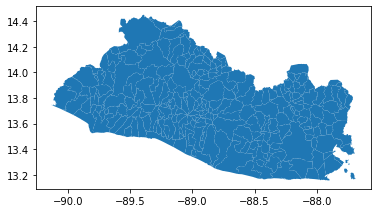

In [ ]:
# Set coordinate reference system to dataset (WGS84 = epsg:4326)
mun_data.crs = 'epsg:4326'
print(mun_data.crs)
mun_data.plot()

In [ ]:
# Create a new dataset based on AMSS municipalities
mun_amss = ['NEJAPA', 'TONACATEPEQUE', 'CUSCATANCINGO', 'APOPA', 'DELGADO', 'AYUTUXTEPEQUE', 'MEJICANOS', 'SAN SALVADOR',
'SAN MARTIN', 'ILOPANGO', 'SOYAPANGO', 'SAN MARCOS', 'ANTIGUO CUSCATLAN', 'SANTA TECLA']
amss_data = mun_data.loc[mun_data.NOM_MUN.isin(mun_amss)]

In [ ]:
# Create a new dataset based on aiditional municipalities, for our case Colon
mun_aditional = ['COLON']
mun_aditional_data = mun_data.loc[mun_data.NOM_MUN.isin(mun_aditional)]

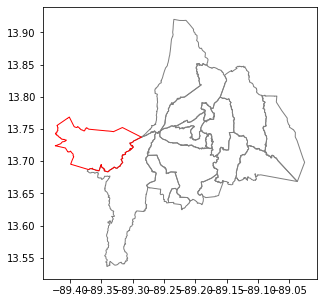

In [ ]:
# Plot amss and colon in a single map to check geometries
ax = amss_data.plot(figsize=(5,5), color='none', edgecolor='gray')
mun_aditional_data.plot(ax=ax, color='none', edgecolor='red')

In [ ]:
# Merge AMSS and aditional municipalities in a single dataframe for our ROI (Region Of Interest)
mun_roi = mun_amss + mun_aditional
roi_data = mun_data.loc[mun_data.NOM_MUN.isin(mun_roi)]

epsg:4326


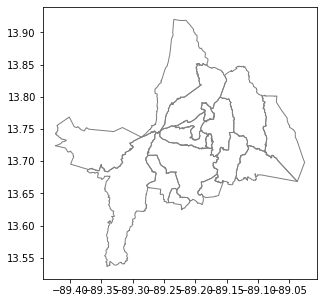

In [ ]:
# Check the CRS for the final df
print(roi_data.crs)
# Plot our ROI
roi_data.plot(figsize=(5,5), color='none', edgecolor='gray')

In [ ]:
# Geographic data for SV
sv_lon = -88.89653
sv_lat = 13.794185
sv_poi = ee.Geometry.Point(sv_lon, sv_lat)

In [ ]:
# Geographic data for AMSS
amss_lon = -89.214763
amss_lat = 13.723560
amss_poi = ee.Geometry.Point(amss_lon, amss_lat)

In [ ]:
# Create json from our ROI geodataframe
roi_json = json.loads(roi_data.to_json())

# Craete Google Earth Engine FeatureCollection from geojson
roi_fc = ee.FeatureCollection(roi_json)

# Create GEE Geometry from FeatureCollection
roi_geom = ee.Geometry(roi_fc.geometry())

## Recortando imágenes Landsat

In [ ]:
# Function that retrieves Landsat Collection ID for a given year
def getLandsatCollectionId(year):
  if year >= 1985 and year <= 1999:
    return 'LT05'
  elif year >= 2000 and year <= 2013:
    return 'LE07'
  elif year >= 2014 and year <= 2021:
    return 'LC08'

In [ ]:
# Define cloud mask for Landsat 4/5/7 images
def cloudMaskL457(img):
  '''  
  Function to mask clouds based on the pixel_qa band of Landsat 4/5/7 SR data. See:
  https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C01_T1_SR
  
  Params:
  -------
  - img: image input Landsat 4/5/7 SR image
  
  Return:
  -------
  cloudmasked Landsat 4/5/7 image
  '''
  # Get the pixel QA band.
  qa = img.select('pixel_qa')
  # If the cloud bit (5) is set and the cloud confidence (7) is high or the cloud shadow bit is set (3), then it's a bad pixel.
  cloud = qa.bitwiseAnd(1 << 5)\
                  .And(qa.bitwiseAnd(1 << 7))\
                  .Or(qa.bitwiseAnd(1 << 3))
  # Remove edge pixels that don't occur in all bands
  mask = img.mask().reduce(ee.Reducer.min())
  return img.updateMask(cloud.Not()).updateMask(mask)  

In [ ]:
# Define cloud mask for Landsat 8 images
def cloudMaskL8(img):
  '''  
  Function to mask clouds based on the pixel_qa band of Landsat 8 SR data. See:
  https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR
  
  Params:
  -------
  - img: image input Landsat 8 SR image
  
  Return:
  -------
  cloudmasked Landsat 8 image
  '''
  cloudShadowBitMask = (1 << 3)
  cloudsBitMask = (1 << 5)
  # Get the pixel QA band.
  qa = img.select('pixel_qa')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0)\
           .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  return img.updateMask(mask)    

In [ ]:
# Function that clips a single Landsat Image given landsat collection ID, a year, a roi and a porcentage of cloud contamination
def clipLandsatImage(year, landsat_id, cloud_contamination, roi):

  landsat_path = 'LANDSAT/' + landsat_id + '/C01/T1_SR'
  initial_date = str(year) + '-01-01'
  end_date = str(year) + '-12-31'

  landsat_collection = ee.ImageCollection(landsat_path)

  clipped_image = landsat_collection\
    .filterBounds(roi)\
    .filterDate(initial_date, end_date)\
    .filter(ee.Filter.lt('CLOUD_COVER', cloud_contamination))\
    .map(cloudMaskL8 if landsat_id == 'LC08' else cloudMaskL457)\
    .median()\
    .clip(roi)

  return clipped_image

In [ ]:
# Function that clips n Landsat Images in a range of years, given a cloud contamination percentage and a roi
def clipLandsatImagesInRange(initial_year, end_year, cloud_contamination, roi):
  clipped_images = []
  for year in range(initial_year, end_year + 1):
    landsat_id = getLandsatCollectionId(year)
    clipped_images.append(clipLandsatImage(year, landsat_id, cloud_contamination, roi_geom))
  return clipped_images

In [ ]:
# Function that clips n Landsat Images in a range of years, given a cloud contamination percentage and a roi
def clipLandsatImagesInRangeList(range_years, cloud_contamination, roi):
  clipped_images = []
  for year in range_years:
    landsat_id = getLandsatCollectionId(year)
    clipped_images.append(clipLandsatImage(year, landsat_id, cloud_contamination, roi_geom))
  return clipped_images

In [ ]:
#clipped_images = clipLandsatImagesInRange(initial_year=1992, end_year=2021, cloud_contamination=30, roi=roi_geom)

In [ ]:
# We define our years of interest for Landsat Imagery
landsat5_years = [1991, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
landsat7_years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
landsat8_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

# Clip landsat images for given year, cloud contamination and ROI geometry
clipped_images_L5 = clipLandsatImagesInRangeList(landsat5_years, 20, roi_geom)
clipped_images_L7 = clipLandsatImagesInRangeList(landsat7_years, 20, roi_geom)
clipped_images_L8 = clipLandsatImagesInRangeList(landsat8_years, 20, roi_geom)

# Concatenate results in a global list 
years_of_interes = landsat5_years + landsat7_years + landsat8_years
clipped_images = clipped_images_L5 + clipped_images_L7 + clipped_images_L8

print('Number of clipped images:', len(clipped_images))

Number of clipped images: 30


## Clasificando las imágenes Landsat

### Preparación previa a la clasificación

In [ ]:
# Retrieving training points from GitHub
train_datasource_url = 'https://raw.githubusercontent.com/CesarRosales16/Urban-Sprawl-SV/main/datasources/train-data-1991/TrainCoverAMSSC.shp'
train_shp_path = '/vsicurl/' + train_datasource_url
train_data = gpd.read_file(train_shp_path)
train_data.head()

Class                    geometry
0      0  POINT (-89.14201 13.72003)
1      0  POINT (-89.12639 13.71928)
2      0  POINT (-89.13214 13.71711)
3      0  POINT (-89.14073 13.71269)
4      0  POINT (-89.14176 13.72445)

In [ ]:
# Create json from geodataframe
train_json = json.loads(train_data.to_json())

In [ ]:
#Importing training data
training = ee.FeatureCollection(train_json)

label = 'Class'
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']

In [ ]:
def classifyGivenImage(classifier, image, train_pct, training, label, bands):
  input = image.select(bands)

  train_image = input.sampleRegions(**{
      'collection': training,
      'properties': [label],
      'scale': 30
  })

  training_data = train_image.randomColumn()

  train_set = training_data.filter(ee.Filter.lessThan('random', train_pct))
  test_set = training_data.filter(ee.Filter.greaterThanOrEquals('random', train_pct))

  # Train our model with the given classifier for the train set
  model = classifier.train(train_set, label, bands)

  # Classify entire image
  classified_image = input.classify(model)

  #Validation:
  validated = test_set.classify(model)

  error_matrix = validated.errorMatrix(label, 'classification')
  overall_accuracy = error_matrix.accuracy().getInfo()
  kappa_index = error_matrix.kappa().getInfo()

  return classified_image, error_matrix.getInfo(), overall_accuracy, kappa_index

In [ ]:
def classifyMultipleImages(classifier, images, train_pct, training, label, bands):
  classified_images = []
  error_matrices = []
  overall_accuracies = []
  kappa_indexes = []
  for image in images:
    print('Classifying image {} ...'.format(len(classified_images)+1))
    classified, error_matrix, overall_accuracy, kappa_index = classifyGivenImage(classifier, image, train_pct, training, label, bands)
    classified_images.append(classified)
    error_matrices.append(error_matrix)
    overall_accuracies.append(overall_accuracy)
    kappa_indexes.append(kappa_index)
  return classified_images, error_matrices, overall_accuracies, kappa_indexes

### CART

In [ ]:
cart_classifier = ee.Classifier.smileCart()
classified_images_cart, error_matrices_cart, overall_accuracies_cart, kappa_indexes_cart = classifyMultipleImages(cart_classifier, clipped_images, 0.80, training, label, bands)

Classifying image 1 ...
Classifying image 2 ...
Classifying image 3 ...
Classifying image 4 ...
Classifying image 5 ...
Classifying image 6 ...
Classifying image 7 ...
Classifying image 8 ...
Classifying image 9 ...
Classifying image 10 ...
Classifying image 11 ...
Classifying image 12 ...
Classifying image 13 ...
Classifying image 14 ...
Classifying image 15 ...
Classifying image 16 ...
Classifying image 17 ...
Classifying image 18 ...
Classifying image 19 ...
Classifying image 20 ...
Classifying image 21 ...
Classifying image 22 ...
Classifying image 23 ...
Classifying image 24 ...
Classifying image 25 ...
Classifying image 26 ...
Classifying image 27 ...
Classifying image 28 ...
Classifying image 29 ...
Classifying image 30 ...


In [ ]:
result_dict = {
    'year': years_of_interes,
    'overall_accuracy': overall_accuracies_cart,
    'kappa_index': kappa_indexes_cart,
    'error_matrices': error_matrices_cart
}

result_cart_df = pd.DataFrame(result_dict)
result_cart_df.head()

year  overall_accuracy  kappa_index                        error_matrices
0  1991          0.946809     0.902287   [[29, 3, 0], [2, 52, 0], [0, 0, 8]]
1  1993          0.938272     0.891942   [[25, 1, 0], [4, 42, 0], [0, 0, 9]]
2  1994          0.927083     0.853595  [[19, 6, 0], [1, 60, 0], [0, 0, 10]]
3  1995          0.935065     0.855805   [[13, 2, 0], [3, 52, 0], [0, 0, 7]]
4  1996          0.946809     0.889697   [[19, 3, 0], [2, 61, 0], [0, 0, 9]]

In [ ]:
result_cart_df.describe()

year  overall_accuracy  kappa_index
count    30.000000         30.000000    30.000000
mean   2006.466667          0.935364     0.875422
std       8.861903          0.026126     0.051949
min    1991.000000          0.886598     0.764535
25%    1999.250000          0.915337     0.839710
50%    2006.500000          0.939374     0.883432
75%    2013.750000          0.951397     0.910854
max    2021.000000          0.989583     0.981363

In [ ]:
print(result_cart_df)

    year  overall_accuracy  kappa_index                        error_matrices
0   1991          0.946809     0.902287   [[29, 3, 0], [2, 52, 0], [0, 0, 8]]
1   1993          0.938272     0.891942   [[25, 1, 0], [4, 42, 0], [0, 0, 9]]
2   1994          0.927083     0.853595  [[19, 6, 0], [1, 60, 0], [0, 0, 10]]
3   1995          0.935065     0.855805   [[13, 2, 0], [3, 52, 0], [0, 0, 7]]
4   1996          0.946809     0.889697   [[19, 3, 0], [2, 61, 0], [0, 0, 9]]
5   1997          0.943925     0.898063  [[32, 6, 0], [0, 59, 0], [0, 0, 10]]
6   1998          0.907407     0.830082  [[22, 6, 0], [4, 61, 0], [0, 0, 15]]
7   1999          0.935484     0.884280  [[23, 0, 0], [6, 52, 0], [0, 0, 12]]
8   2000          0.989583     0.981363   [[33, 0, 0], [1, 53, 0], [0, 0, 9]]
9   2001          0.942529     0.895983   [[25, 3, 0], [2, 48, 0], [0, 0, 9]]
10  2002          0.987952     0.975603   [[24, 0, 0], [1, 53, 0], [0, 0, 5]]
11  2003          0.968085     0.935247   [[24, 1, 0], [2, 60, 0

In [ ]:
result_cart_df.to_csv('class_cart_results.csv')

### Random Forest

In [ ]:
rf_classifier = ee.Classifier.smileRandomForest(10)
classified_images_rf, error_matrices_rf, overall_accuracies_rf, kappa_indexes_rf = classifyMultipleImages(rf_classifier, clipped_images, 0.80, training, label, bands)

Classifying image 1 ...
Classifying image 2 ...
Classifying image 3 ...
Classifying image 4 ...
Classifying image 5 ...
Classifying image 6 ...
Classifying image 7 ...
Classifying image 8 ...
Classifying image 9 ...
Classifying image 10 ...
Classifying image 11 ...
Classifying image 12 ...
Classifying image 13 ...
Classifying image 14 ...
Classifying image 15 ...
Classifying image 16 ...
Classifying image 17 ...
Classifying image 18 ...
Classifying image 19 ...
Classifying image 20 ...
Classifying image 21 ...
Classifying image 22 ...
Classifying image 23 ...
Classifying image 24 ...
Classifying image 25 ...
Classifying image 26 ...
Classifying image 27 ...
Classifying image 28 ...
Classifying image 29 ...
Classifying image 30 ...


In [ ]:
result_dict = {
    'year': years_of_interes,
    'overall_accuracy': overall_accuracies_rf,
    'kappa_index': kappa_indexes_rf,
    'error_matrices': error_matrices_rf
}

result_rf_df = pd.DataFrame(result_dict)
result_rf_df.head()

year  overall_accuracy  kappa_index                        error_matrices
0  1991          0.936170     0.883278   [[29, 3, 0], [3, 51, 0], [0, 0, 8]]
1  1993          0.975309     0.956545   [[26, 0, 0], [2, 44, 0], [0, 0, 9]]
2  1994          0.947917     0.895425  [[20, 5, 0], [0, 61, 0], [0, 0, 10]]
3  1995          0.961039     0.910811   [[13, 2, 0], [1, 54, 0], [0, 0, 7]]
4  1996          0.968085     0.933818   [[20, 2, 0], [1, 62, 0], [0, 0, 9]]

In [ ]:
result_rf_df.describe()

year  overall_accuracy  kappa_index
count    30.000000         30.000000    30.000000
mean   2006.466667          0.952429     0.908389
std       8.861903          0.021160     0.040113
min    1991.000000          0.901099     0.821140
25%    1999.250000          0.943314     0.886315
50%    2006.500000          0.953322     0.910809
75%    2013.750000          0.966098     0.934933
max    2021.000000          0.989583     0.981363

In [ ]:
print(result_rf_df)

    year  overall_accuracy  kappa_index                        error_matrices
0   1991          0.936170     0.883278   [[29, 3, 0], [3, 51, 0], [0, 0, 8]]
1   1993          0.975309     0.956545   [[26, 0, 0], [2, 44, 0], [0, 0, 9]]
2   1994          0.947917     0.895425  [[20, 5, 0], [0, 61, 0], [0, 0, 10]]
3   1995          0.961039     0.910811   [[13, 2, 0], [1, 54, 0], [0, 0, 7]]
4   1996          0.968085     0.933818   [[20, 2, 0], [1, 62, 0], [0, 0, 9]]
5   1997          0.915888     0.848609  [[32, 6, 0], [3, 56, 0], [0, 0, 10]]
6   1998          0.962963     0.932815  [[26, 2, 0], [2, 63, 0], [0, 0, 15]]
7   1999          0.978495     0.959670  [[22, 1, 0], [1, 57, 0], [0, 0, 12]]
8   2000          0.989583     0.981363   [[33, 0, 0], [1, 53, 0], [0, 0, 9]]
9   2001          0.965517     0.936926   [[25, 3, 0], [0, 50, 0], [0, 0, 9]]
10  2002          0.975904     0.951632   [[24, 0, 0], [2, 52, 0], [0, 0, 5]]
11  2003          0.957447     0.912923   [[23, 2, 0], [2, 60, 0

In [ ]:
result_rf_df.to_csv('class_rf_results.csv')

### SVM con kernel lineal

In [ ]:
svm_classifier = ee.Classifier.libsvm()
classified_images_svm, error_matrices_svm, overall_accuracies_svm, kappa_indexes_svm = classifyMultipleImages(svm_classifier, clipped_images, 0.80, training, label, bands)

Classifying image 1 ...
Classifying image 2 ...
Classifying image 3 ...
Classifying image 4 ...
Classifying image 5 ...
Classifying image 6 ...
Classifying image 7 ...
Classifying image 8 ...
Classifying image 9 ...
Classifying image 10 ...
Classifying image 11 ...
Classifying image 12 ...
Classifying image 13 ...
Classifying image 14 ...
Classifying image 15 ...
Classifying image 16 ...
Classifying image 17 ...
Classifying image 18 ...
Classifying image 19 ...
Classifying image 20 ...
Classifying image 21 ...
Classifying image 22 ...
Classifying image 23 ...
Classifying image 24 ...
Classifying image 25 ...
Classifying image 26 ...
Classifying image 27 ...
Classifying image 28 ...
Classifying image 29 ...
Classifying image 30 ...


In [ ]:
result_dict = {
    'year': years_of_interes,
    'overall_accuracy': overall_accuracies_svm,
    'kappa_index': kappa_indexes_svm,
    'error_matrices': error_matrices_svm
}

result_svm_df = pd.DataFrame(result_dict)
result_svm_df.head()

year  overall_accuracy  kappa_index                        error_matrices
0  1991          0.627660     0.398537  [[29, 3, 0], [32, 22, 0], [0, 0, 8]]
1  1993          0.444444     0.006270  [[3, 23, 0], [22, 24, 0], [0, 0, 9]]
2  1994          0.927083     0.855856  [[20, 5, 0], [2, 59, 0], [0, 0, 10]]
3  1995          0.961039     0.916000   [[15, 0, 0], [3, 52, 0], [0, 0, 7]]
4  1996          0.957447     0.910900   [[19, 3, 0], [1, 62, 0], [0, 0, 9]]

In [ ]:
result_svm_df.describe()

year  overall_accuracy  kappa_index
count    30.000000         30.000000    30.000000
mean   2006.466667          0.909601     0.833238
std       8.861903          0.108956     0.188638
min    1991.000000          0.444444     0.006270
25%    1999.250000          0.909471     0.832011
50%    2006.500000          0.934589     0.870135
75%    2013.750000          0.960141     0.915973
max    2021.000000          0.989583     0.981210

In [ ]:
print(result_svm_df)

    year  overall_accuracy  kappa_index                        error_matrices
0   1991          0.627660     0.398537  [[29, 3, 0], [32, 22, 0], [0, 0, 8]]
1   1993          0.444444     0.006270  [[3, 23, 0], [22, 24, 0], [0, 0, 9]]
2   1994          0.927083     0.855856  [[20, 5, 0], [2, 59, 0], [0, 0, 10]]
3   1995          0.961039     0.916000   [[15, 0, 0], [3, 52, 0], [0, 0, 7]]
4   1996          0.957447     0.910900   [[19, 3, 0], [1, 62, 0], [0, 0, 9]]
5   1997          0.953271     0.915894  [[34, 4, 0], [1, 58, 0], [0, 0, 10]]
6   1998          0.907407     0.830082  [[22, 6, 0], [4, 61, 0], [0, 0, 15]]
7   1999          0.989247     0.979987  [[23, 0, 0], [1, 57, 0], [0, 0, 12]]
8   2000          0.989583     0.981210   [[32, 1, 0], [0, 54, 0], [0, 0, 9]]
9   2001          0.931034     0.871807   [[22, 6, 0], [0, 50, 0], [0, 0, 9]]
10  2002          0.915663     0.837800   [[24, 0, 0], [7, 47, 0], [0, 0, 5]]
11  2003          0.893617     0.782307   [[20, 5, 0], [5, 57, 0

In [ ]:
result_svm_df.to_csv('class_svm_results.csv')

### SVM con RBF

In [ ]:
svm_rbf_classifier = ee.Classifier.libsvm(kernelType='RBF')
classified_images_svm_rbf, error_matrices_svm_rbf, overall_accuracies_svm_rbf, kappa_indexes_svm_rbf = classifyMultipleImages(svm_rbf_classifier, clipped_images, 0.80, training, label, bands)

Classifying image 1 ...
Classifying image 2 ...
Classifying image 3 ...
Classifying image 4 ...
Classifying image 5 ...
Classifying image 6 ...
Classifying image 7 ...
Classifying image 8 ...
Classifying image 9 ...
Classifying image 10 ...
Classifying image 11 ...
Classifying image 12 ...
Classifying image 13 ...
Classifying image 14 ...
Classifying image 15 ...
Classifying image 16 ...
Classifying image 17 ...
Classifying image 18 ...
Classifying image 19 ...
Classifying image 20 ...
Classifying image 21 ...
Classifying image 22 ...
Classifying image 23 ...
Classifying image 24 ...
Classifying image 25 ...
Classifying image 26 ...
Classifying image 27 ...
Classifying image 28 ...
Classifying image 29 ...
Classifying image 30 ...


In [ ]:
result_dict = {
    'year': years_of_interes,
    'overall_accuracy': overall_accuracies_svm_rbf,
    'kappa_index': kappa_indexes_svm_rbf,
    'error_matrices': error_matrices_svm_rbf
}

result_svm_rbf_df = pd.DataFrame(result_dict)
result_svm_rbf_df.head()

year  overall_accuracy  kappa_index                       error_matrices
0  1991          0.606383     0.107748  [[0, 32, 0], [0, 54, 0], [0, 5, 3]]
1  1993          0.604938     0.120163  [[0, 26, 0], [0, 46, 0], [0, 6, 3]]
2  1994          0.645833     0.043096  [[0, 25, 0], [0, 61, 0], [0, 9, 1]]
3  1995          0.740260     0.139665  [[0, 15, 0], [0, 55, 0], [0, 5, 2]]
4  1996          0.723404     0.232412  [[0, 22, 0], [0, 63, 0], [0, 4, 5]]

In [ ]:
result_svm_rbf_df.describe()

year  overall_accuracy  kappa_index
count    30.000000         30.000000    30.000000
mean   2006.466667          0.640962     0.091813
std       8.861903          0.052583     0.089095
min    1991.000000          0.510638     0.000000
25%    1999.250000          0.607565     0.007351
50%    2006.500000          0.648272     0.072781
75%    2013.750000          0.665730     0.134804
max    2021.000000          0.740260     0.290019

In [ ]:
print(result_svm_rbf_df)

    year  overall_accuracy  kappa_index                        error_matrices
0   1991          0.606383     0.107748   [[0, 32, 0], [0, 54, 0], [0, 5, 3]]
1   1993          0.604938     0.120163   [[0, 26, 0], [0, 46, 0], [0, 6, 3]]
2   1994          0.645833     0.043096   [[0, 25, 0], [0, 61, 0], [0, 9, 1]]
3   1995          0.740260     0.139665   [[0, 15, 0], [0, 55, 0], [0, 5, 2]]
4   1996          0.723404     0.232412   [[0, 22, 0], [0, 63, 0], [0, 4, 5]]
5   1997          0.560748     0.030087   [[0, 38, 0], [0, 59, 0], [0, 9, 1]]
6   1998          0.611111     0.033660  [[0, 28, 0], [0, 65, 0], [0, 14, 1]]
7   1999          0.655914     0.122900   [[0, 23, 0], [0, 58, 0], [0, 9, 3]]
8   2000          0.572917     0.034584   [[0, 33, 0], [0, 54, 0], [0, 8, 1]]
9   2001          0.574713     0.000000   [[0, 28, 0], [0, 50, 0], [0, 9, 0]]
10  2002          0.662651     0.053746   [[0, 24, 0], [0, 54, 0], [0, 4, 1]]
11  2003          0.659574     0.000000   [[0, 25, 0], [0, 62, 0

In [ ]:
result_svm_rbf_df.to_csv('class_svm_rbf_results.csv')

## Visualización de mapas

In [ ]:
def mapSingleLayer(layer, layar_vis_params, layer_name, folium_width='100%', folium_height=None):

  f = folium.Figure(width=folium_width, height=folium_height)

  my_map = folium.Map(location=[amss_lat, amss_lon], zoom_start=10, max_bounds=True, min_zoom=1.5).add_to(f)

  # Boundaries layer for our ROI
  my_map.add_ee_layer(roi_fc.draw('006600', 3, 2), {}, 'ROI Boundaries')

  # Layer of interest
  my_map.add_ee_layer(layer, layar_vis_params, layer_name)
  
  my_map.add_child(folium.LayerControl())

  display(my_map)

In [ ]:
def mapClippedAndClassifiedForAYear(year, years, clipped, clipped_params, classified, classified_params, folium_width='100%', folium_height=None):

  f = folium.Figure(width=folium_width, height=folium_height)

  my_map = folium.Map(location=[amss_lat, amss_lon], zoom_start=10, max_bounds=True, min_zoom=1.5).add_to(f)

  # Boundaries layer
  my_map.add_ee_layer(roi_fc.draw('006600', 3, 2), {}, 'ROI Boundaries')
  
  # Get index for desired year
  index = years.index(year)

  # Clipped Image layer
  my_map.add_ee_layer(clipped[index], clipped_params, 'Landsat ' + str(year))
  
  # Classified image mayer
  my_map.add_ee_layer(classified[index], classified_params, 'Classification ' + str(year))

  # Add a layer control panel to the map
  my_map.add_child(folium.LayerControl())

  display(my_map)

In [ ]:
# Set visualization parameters for Landsat 8 images
vis_params_L8 = {
    'bands':['B4', 'B3', 'B2'], 
    'min': 0, 
    'max': 3000, 
    'gamma': 1.4
}

# Set visualization parameters for Landsat 4/5/7 images
vis_params_L457 = {
    'bands':['B3', 'B2', 'B1'], 
    'min': 0, 
    'max': 3000, 
    'gamma': 1.4
}

# Define palette for the clasification
land_cover_palette = [
                      '#E31A1C', # urban (0)
                      '#005A32', # land  (1)
                      '#0C2C84', # water (2)
]

# Set visualization parameters for classification layers
land_cover_params = {
    'palette': land_cover_palette, 
    'min': 0, 
    'max': 2
}

In [ ]:
mapClippedAndClassifiedForAYear(1991, years_of_interes, clipped_images, vis_params_L457, classified_images_rf, land_cover_params, '75%', 500)

## Capas adicionales para modelo de predicción


In [ ]:
# Digital Elevation Model (DEM)
dem = ee.Image("USGS/SRTMGL1_003").clip(roi_geom)
dem_vis_params = {'min': 0, 'max': 6000}
mapSingleLayer(dem, dem_vis_params, 'DEM AMSSS', '75%', 500)

In [ ]:
# Slope
elevation = dem.select('elevation')
slope = ee.Terrain.slope(elevation);
slope_vis_params = {'min': 0, 'max': 60}
mapSingleLayer(slope, slope_vis_params, 'Slope AMSSS', '75%', 500)

In [ ]:
# Aspect
aspect = ee.Terrain.aspect(elevation);
aspect_vis_params = {'min': 0, 'max': 359.99}
mapSingleLayer(aspect, aspect_vis_params, 'Aspect AMSSS', '75%', 500)

In [ ]:
# Hillshade
terrain = ee.Terrain.products(dem)
hillshade = terrain.select('hillshade')
hillshade_vis_params = {min: 0, max: 255}
mapSingleLayer(hillshade, hillshade_vis_params, 'Hillshade AMSSS', '75%', 500)

## Exportando imagenes como GeoTIFF

In [ ]:
# Path where geotiff files are saved
drive_path = "GeoTIFF-Molusce-Final"

In [ ]:
# Export the image, specifying scale and region.
def exportImageToDrive(image_to_export, name, drive_folder, image_scale, region, crs):

  task = ee.batch.Export.image.toDrive(**{
      'image': image_to_export,
      'description': name,
      'folder': drive_folder,
      'crs': crs,
      'scale': image_scale,
      'region': region
  })
  task.start()

  while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(10)

In [ ]:
def exportImagesInRangeToDrive(images, range_list):
  for i in range(len(range_list)):
    name = 'LC01T1SR_RF_' + str(range_list[i])
    print("Exporting", name)
    exportImageToDrive(images[i], name, drive_path, 30, roi_geom, 'EPSG:4326')

Exportando imágenes clasificadas.

In [ ]:
exportImageToDrive(classified_images_rf[0], 'LULC_RF_1991', drive_path, 30, roi_geom, 'EPSG:4326')

Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).


In [ ]:
exportImageToDrive(classified_images_rf[13], 'LULC_RF_2005', drive_path, 30, roi_geom, 'EPSG:4326')

Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).


In [ ]:
exportImageToDrive(classified_images_rf[27], 'LULC_RF_2019', drive_path, 30, roi_geom, 'EPSG:4326')

Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).


In [ ]:
exportImagesInRangeToDrive(classified_images_rf, years_of_interes)

Exporting LC01T1SR_RF_1991
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Exporting LC01T1SR_RF_1993
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for tas

Exportando imagenes DEM.

In [ ]:
exportImageToDrive(dem, 'DEM_AMSS', 'DEM-FINAL', 30, roi_geom, 'EPSG:4326')

Polling for task (id: NJ55Z74FY67GOGBXK6LN7CIM).
Polling for task (id: NJ55Z74FY67GOGBXK6LN7CIM).
Polling for task (id: NJ55Z74FY67GOGBXK6LN7CIM).
Polling for task (id: NJ55Z74FY67GOGBXK6LN7CIM).
Polling for task (id: NJ55Z74FY67GOGBXK6LN7CIM).
Polling for task (id: NJ55Z74FY67GOGBXK6LN7CIM).


In [ ]:
exportImageToDrive(slope, 'SLOPE_AMSS', 'DEM-FINAL', 30, roi_geom, 'EPSG:4326')

Polling for task (id: TPATVF3I6RPXWZRJL3E6M7JM).
Polling for task (id: TPATVF3I6RPXWZRJL3E6M7JM).
Polling for task (id: TPATVF3I6RPXWZRJL3E6M7JM).
Polling for task (id: TPATVF3I6RPXWZRJL3E6M7JM).
Polling for task (id: TPATVF3I6RPXWZRJL3E6M7JM).
Polling for task (id: TPATVF3I6RPXWZRJL3E6M7JM).


In [ ]:
exportImageToDrive(aspect, 'ASPECT_AMSS', 'DEM-FINAL', 30, roi_geom, 'EPSG:4326')

Polling for task (id: FK6JPGKRPP3RPF5SMQ4XYV3N).
Polling for task (id: FK6JPGKRPP3RPF5SMQ4XYV3N).
Polling for task (id: FK6JPGKRPP3RPF5SMQ4XYV3N).
Polling for task (id: FK6JPGKRPP3RPF5SMQ4XYV3N).
Polling for task (id: FK6JPGKRPP3RPF5SMQ4XYV3N).
Polling for task (id: FK6JPGKRPP3RPF5SMQ4XYV3N).


In [ ]:
exportImageToDrive(hillshade, 'HILLSHADE_AMSS', 'DEM-FINAL', 30, roi_geom, 'EPSG:4326')

Polling for task (id: IYKLINCP2ROKOSKZBHIALCIN).
Polling for task (id: IYKLINCP2ROKOSKZBHIALCIN).
Polling for task (id: IYKLINCP2ROKOSKZBHIALCIN).
Polling for task (id: IYKLINCP2ROKOSKZBHIALCIN).
Polling for task (id: IYKLINCP2ROKOSKZBHIALCIN).
